# Multi Armed Bandit Simulations

Multi-armed bandit algorithms optimise a target metric by learning which choice of $K$ actions (a.k.a. "arms") to take. The value of the metric after taking an action is considered a reward for that action.  In making a choice of action there is a tradeoff between exploring each action in order to better understand its expected reward, or exploiting the action that has led to the best rewards in the past. Bandit algorithms are applied in marketing, finance, conversion rate optimisation and clinical trials. 

In this notebook I compare sims from two popular bandit algorithms - Thompson sampling, which is based on the Bayesian update to a binomial mean from a beta prior, and the Upper Confidence Bound algorithm, which uses Hoeffding's inequality to bound the mean. This post is designed to highlight my fluency with Python and these algorithms - rather than providing a serious scientific comparison of the two methods. 

My bandit algorithms, reward and some utility functions are packaged in the `bandits` module imported above. The software lives in my [github portfolio](https://github.com/c-ldwc/Portfolio/tree/main/Bandits/bandits). The algorithms are found in the [bandit algorithm classes file](https://github.com/c-ldwc/Portfolio/blob/main/Bandits/bandits/banditClasses.py). 

I simulated bandits with a time horizon $T$ of 10,000. Each bandit was simulated 500 times. Giving me 1,000 observations at each T for both UCB and Thompson sampling. The bandits sampled from 2 arms, both returned Bernoulli rewards with p = 0.2 and p = 0.3. We want to know how our algorithm performs, on average, relative to the best performance. This is known as regret and is defined as 
$$R = \Sigma_{i=1}^{T}\left[\mu(a^*) - \mu(a_t)\right]$$ 

where $\mu(a^*)$ is the mean for the best action and $\mu(a_t)$ is the mean for the action chosen at time $t$. For our rewards it is 

$$R = T*.3 - \Sigma_{i=1}^{T}\mu(a_t)$$

{:toc}

In [1]:
import pandas as pd

import os

import bandits #bandit algos and rewards
from simulation_help import ( #plotting and simulation functions
    bandit_summaries,
    simulate,
    TS_single_sim,
    ucb_single_sim,
    mean_plots,
    regret_plots,
    bound_plots,
)

arm_mu = [0.2, 0.3]  # True means for the binomial reward
T = 10_000  # Time horizon for each bandit
n_sims = 500  # Number of bandits to simulate

## Simulations

In [2]:
# stationary simulations
if not os.path.exists("simulations.csv"):
    rg = bandits.binom_reward_generator(arm_mu, N=1)
    TS_data = simulate(
        N=n_sims, T=T, arm_mu=arm_mu, single_sim=TS_single_sim, reward_fn=rg.reward
    )
    ucb_data = simulate(
        N=n_sims,
        T=T,
        n_out=T - len(arm_mu),
        arm_mu=arm_mu,
        single_sim=ucb_single_sim,
        reward_fn=rg.reward,
    )

    TS_data["source"] = "Thompson Sampling"
    ucb_data["source"] = "UCB"
    sims = pd.concat([TS_data, ucb_data], axis=0)
    sims["act"] = sims["act"].astype(int)
    sims.to_csv("simulations.csv")
else:
    sims = pd.read_csv("simulations.csv")

# Compute summaries (means, cumulative regret etc.)

In [3]:
stat_summaries = bandit_summaries(sims, arm_mu)

# Stationary Rewards
## Mean reward for each action over time 

Here we see how the mean rewards for each action over each iteration of the bandit algos evolve. Each blue line is a run of the bandit simulator. The x axis is the $t^{th}$ performance of the relevant action each run. At x = 1000 in the top left plot we see the mean reward for the first action for all Thompson sampling runs that chose that action 1000 or more times. 

We can see that Thompson sampling tends to learn about the poorer action (k = 0) early on and rarely runs it more than about 400 times. The UCB algorithm however takes much longer for its intervals to converge to a point where this action is obviously not a winner. 

100%|██████████| 500/500 [00:32<00:00, 15.22it/s]


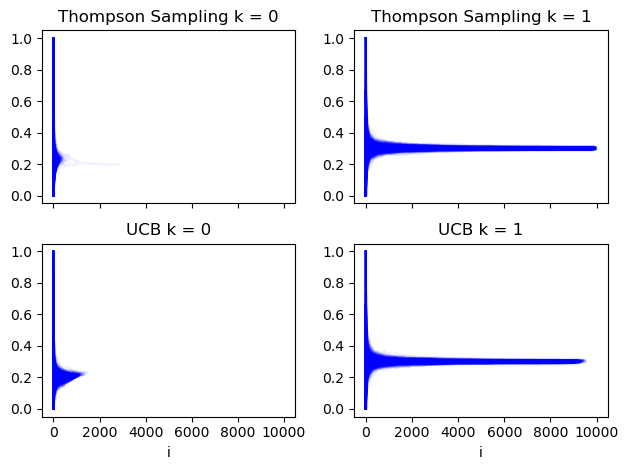

In [4]:
mean_plots(stat_summaries["running_means"]);

## Regret
The plots below show the cumulative regret at each point during a simulation run. Each line represents a bandit simulation. Thompson sampling appears initially linear (i.e. described by a power law because these are log-log plots) and levels off around t = 1000. UCB does not show this patter and attains a higher regret than almost all Thompson Sampling simulations. 

100%|██████████| 499/499 [00:00<00:00, 535.24it/s]


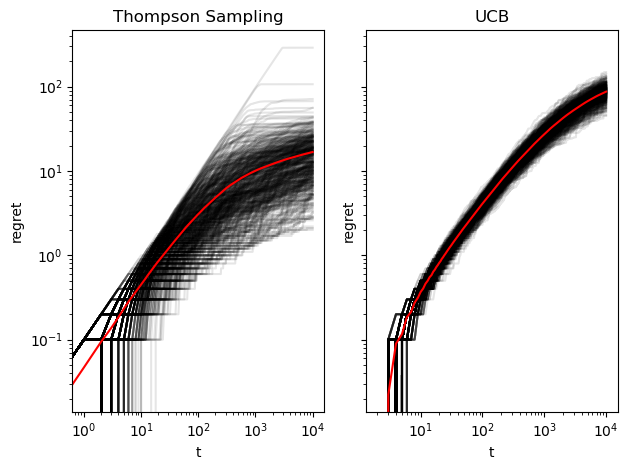

In [5]:
regret_plots(stat_summaries["regret_trajectories"], T);

## Parameter Bounds

Finally, we can view the bounds on the estimates of the mean for each algorithm. For Thompson sampling these are the 95% quantiles of the posterior distribution. For the UCB algorithm they are the confidence intervals derived from the Hoeffding Inequality (these can be $\lt 0$).  We can see that UCB's bounds are wider than Thompson sampling, but this is slightly arbitrary because it depends on my choice of quantile for the Thompson posterior. 

100%|██████████| 499/499 [00:02<00:00, 224.76it/s]


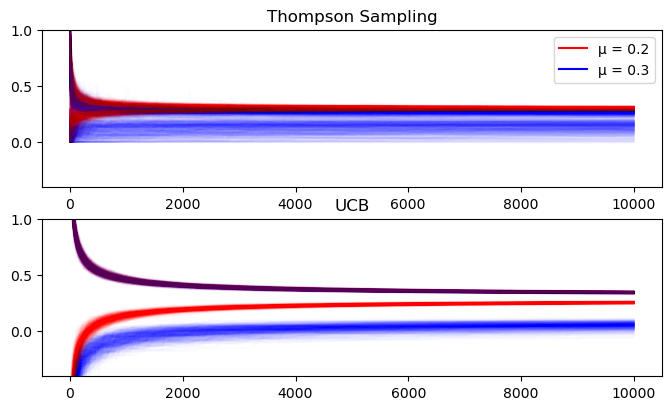

In [6]:
bound_plots(sims);

# Non-Stationary Simulations

In addition to the above stationary rewards, we want to see what happens when the mean is changing over time. For e-commerce, this is pretty common. Conversion is more likely at certain times of the week (i.e. weekends), or year (i.e. sales events). To simulate this I have a reward generator that increases the Bernoulli parameter by .1 every 6th and 7th day - corresponding to a weekend bump in conversions. Note that this preserves the ranking of the actions. 

I do this because these two algorithms are predicated on stationary reward distributions, but such distributions are very rare for almost all metrics we care about. Checking that the algorithms' decisions are robust to deviations from their ideal cases is vital if we want to deploy these to automate decision making.

The plots below show very little in terms of interesting changes due to the non-stationarity - probably because the weekend bump preserves the order of the two arms' means. 

In [7]:
# non-stationary simulations
if not os.path.exists("non_stat_simulations.csv"):
    rg = bandits.binom_weekend_reward(arm_mu, N=1)
    TS_data = simulate(
        N=n_sims, T=T, arm_mu=arm_mu, single_sim=TS_single_sim, reward_fn=rg.reward
    )
    ucb_data = simulate(
        N=n_sims,
        T=T,
        n_out=T - len(arm_mu),
        arm_mu=arm_mu,
        single_sim=ucb_single_sim,
        reward_fn=rg.reward,
    )

    TS_data["source"] = "Thompson Sampling"
    ucb_data["source"] = "UCB"
    ns_sim = pd.concat([TS_data, ucb_data], axis=0)
    ns_sim["act"] = ns_sim["act"].astype(int)
    ns_sim.to_csv("non_stat_simulations.csv")
else:
    ns_sim = pd.read_csv("non_stat_simulations.csv")

ns_summaries = bandit_summaries(ns_sim, arm_mu)

100%|██████████| 500/500 [00:33<00:00, 15.09it/s]


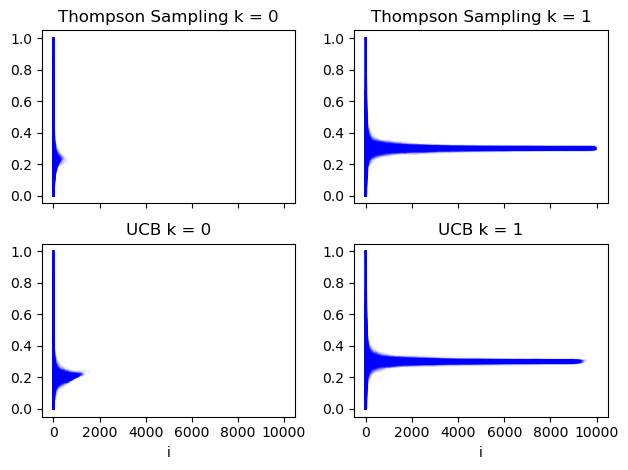

In [8]:
mean_plots(ns_summaries["running_means"]);

100%|██████████| 499/499 [00:00<00:00, 581.05it/s]


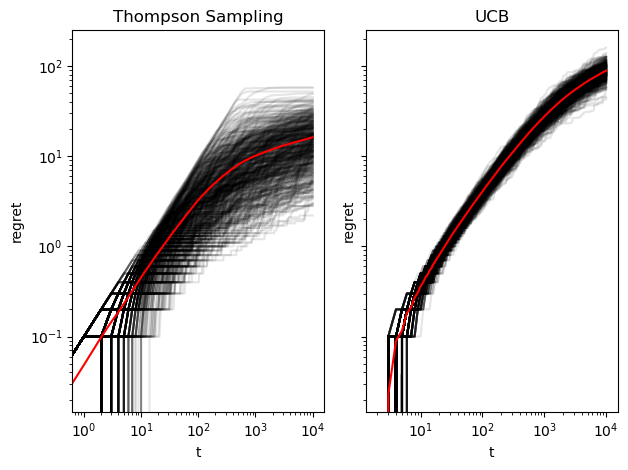

In [9]:
regret_plots(ns_summaries["regret_trajectories"], T);

100%|██████████| 499/499 [00:02<00:00, 223.29it/s]


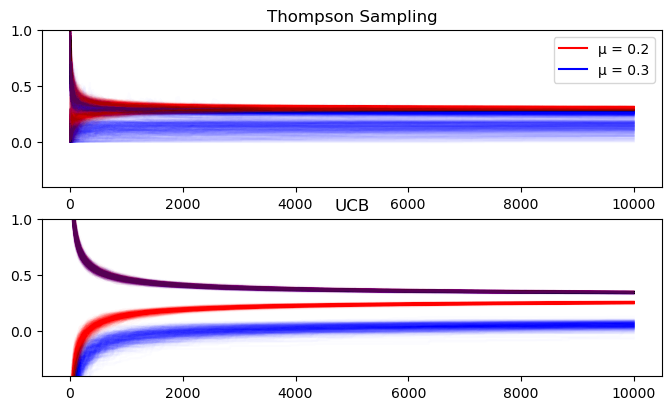

In [10]:
bound_plots(ns_sim);